In [118]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince



In [119]:
rfm_df = pd.read_csv('datasets/rfm.csv')
rfm_df

customer_id  Recency  Frequency  MonetaryValue
0      00012a2ce6f8dcda20d059ce98491703      293          1         114.74
1      000161a058600d5901f007fab4c27140      414          1          67.41
2      0001fd6190edaaf884bcaf3d49edf079      552          1         195.42
3      0002414f95344307404f0ace7a26f1d5      383          1         179.35
4      000379cdec625522490c315e70c7a9fb      154          1         107.01
...                                 ...      ...        ...            ...
98660  fffcb937e9dd47a13f05ecb8290f4d3e      171          1          91.91
98661  fffecc9f79fd8c764f843e9951b11341      158          3         244.08
98662  fffeda5b6d849fbd39689bb92087f431      104          1          63.13
98663  ffff42319e9b2d713724ae527742af25       82          1         214.13
98664  ffffa3172527f765de70084a7e53aae8      366          1          45.50

[98665 rows x 4 columns]

In [120]:
rfm_df.describe()

Recency     Frequency  MonetaryValue
count  98665.000000  98665.000000   98665.000000
mean     245.811017      1.044504     167.906997
std      153.386320      0.379259     254.725916
min        1.000000      1.000000      10.070000
25%      122.000000      1.000000      62.910000
50%      227.000000      1.000000     107.440000
75%      356.000000      1.000000     182.290000
max      729.000000     29.000000   13664.080000

In [121]:
# rfm_df.set_index('customer_id')

from sklearn.preprocessing import MinMaxScaler

rfm_df_scaled = rfm_df.copy()
scaler = MinMaxScaler()
rfm_df_scaled.iloc[:, 1:] = scaler.fit_transform(rfm_df.iloc[:, 1:])
rfm_df_scaled

customer_id   Recency  Frequency  MonetaryValue
0      00012a2ce6f8dcda20d059ce98491703  0.401099   0.000000       0.007666
1      000161a058600d5901f007fab4c27140  0.567308   0.000000       0.004199
2      0001fd6190edaaf884bcaf3d49edf079  0.756868   0.000000       0.013575
3      0002414f95344307404f0ace7a26f1d5  0.524725   0.000000       0.012398
4      000379cdec625522490c315e70c7a9fb  0.210165   0.000000       0.007100
...                                 ...       ...        ...            ...
98660  fffcb937e9dd47a13f05ecb8290f4d3e  0.233516   0.000000       0.005994
98661  fffecc9f79fd8c764f843e9951b11341  0.215659   0.071429       0.017139
98662  fffeda5b6d849fbd39689bb92087f431  0.141484   0.000000       0.003886
98663  ffff42319e9b2d713724ae527742af25  0.111264   0.000000       0.014945
98664  ffffa3172527f765de70084a7e53aae8  0.501374   0.000000       0.002595

[98665 rows x 4 columns]

In [122]:
from sklearn.pipeline import Pipeline

# https://github.com/yzhao062/pyod
clf = ECOD()

clf.fit(rfm_df_scaled.iloc[:, 1:])
outliers = clf.predict(rfm_df_scaled.iloc[:, 1:])

rfm_df_scaled['outlier'] = outliers
rfm_df['outlier'] = outliers

rfm_scaled_no_outliers = rfm_df_scaled[rfm_df_scaled['outlier'] == 0]
rfm_scaled_no_outliers = rfm_scaled_no_outliers.drop('outlier', axis=1)

rfm_scaled_no_outliers

customer_id   Recency  Frequency  MonetaryValue
0      00012a2ce6f8dcda20d059ce98491703  0.401099        0.0       0.007666
1      000161a058600d5901f007fab4c27140  0.567308        0.0       0.004199
2      0001fd6190edaaf884bcaf3d49edf079  0.756868        0.0       0.013575
3      0002414f95344307404f0ace7a26f1d5  0.524725        0.0       0.012398
4      000379cdec625522490c315e70c7a9fb  0.210165        0.0       0.007100
...                                 ...       ...        ...            ...
98659  fffb97495f78be80e2759335275df2aa  0.314560        0.0       0.003731
98660  fffcb937e9dd47a13f05ecb8290f4d3e  0.233516        0.0       0.005994
98662  fffeda5b6d849fbd39689bb92087f431  0.141484        0.0       0.003886
98663  ffff42319e9b2d713724ae527742af25  0.111264        0.0       0.014945
98664  ffffa3172527f765de70084a7e53aae8  0.501374        0.0       0.002595

[88798 rows x 4 columns]

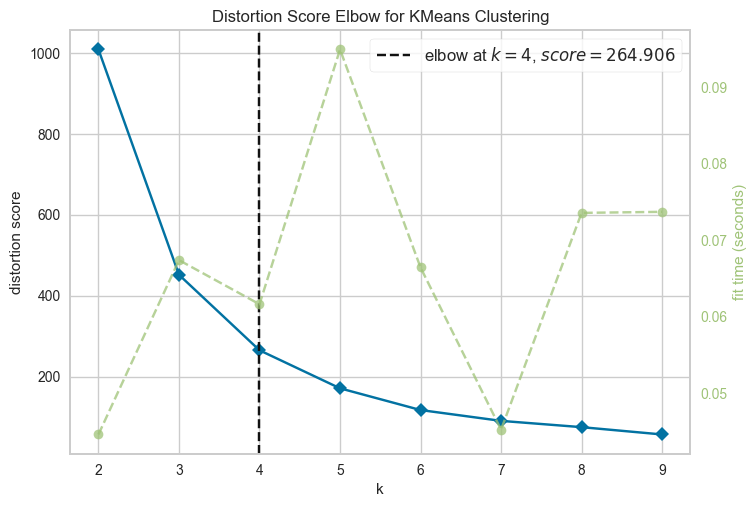

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [123]:
kmeans = KMeans(init='k-means++', random_state=0, n_init='auto')

visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(rfm_scaled_no_outliers.iloc[:, 1:])
visualizer.show()

In [124]:
def make_Silhouette_plot(X, n_clusters):
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )
# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
        plt.xlabel("The silhouette coefficient values", fontsize=24)
        plt.ylabel("Cluster label", fontsize=24)
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])  
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
range_n_clusters = list(range(2,10))
for n_clusters in range_n_clusters:
    print(f"N cluster: {n_clusters}")
    make_Silhouette_plot(rfm_scaled_no_outliers.iloc[:, 1:], n_clusters)   
    plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
    plt.close()

N cluster: 2
For n_clusters = 2 The average silhouette_score is : 0.5916645600085928
N cluster: 3
For n_clusters = 3 The average silhouette_score is : 0.5677011649088726
N cluster: 4
For n_clusters = 4 The average silhouette_score is : 0.5470361090785909
N cluster: 5
For n_clusters = 5 The average silhouette_score is : 0.5414859117201851
N cluster: 6
For n_clusters = 6 The average silhouette_score is : 0.5447586783828771
N cluster: 7
For n_clusters = 7 The average silhouette_score is : 0.5329074232026132
N cluster: 8
For n_clusters = 8 The average silhouette_score is : 0.5190085930998477
N cluster: 9
For n_clusters = 9 The average silhouette_score is : 0.5263157701587851


In [125]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(rfm_scaled_no_outliers.iloc[:, 1:])
print(km.inertia_)

451.6167441106155


In [126]:
np.unique(clusters_predict)

array([0, 1, 2])

In [127]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(rfm_scaled_no_outliers.iloc[:, 1:],clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(rfm_scaled_no_outliers.iloc[:, 1:],clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(rfm_scaled_no_outliers.iloc[:, 1:],clusters_predict)}")

Davies bouldin score: 0.5303937905680276
Calinski Score: 289027.8739517795
Silhouette Score: 0.5677412927011561


In [128]:
rfm_scaled_no_outliers

customer_id   Recency  Frequency  MonetaryValue
0      00012a2ce6f8dcda20d059ce98491703  0.401099        0.0       0.007666
1      000161a058600d5901f007fab4c27140  0.567308        0.0       0.004199
2      0001fd6190edaaf884bcaf3d49edf079  0.756868        0.0       0.013575
3      0002414f95344307404f0ace7a26f1d5  0.524725        0.0       0.012398
4      000379cdec625522490c315e70c7a9fb  0.210165        0.0       0.007100
...                                 ...       ...        ...            ...
98659  fffb97495f78be80e2759335275df2aa  0.314560        0.0       0.003731
98660  fffcb937e9dd47a13f05ecb8290f4d3e  0.233516        0.0       0.005994
98662  fffeda5b6d849fbd39689bb92087f431  0.141484        0.0       0.003886
98663  ffff42319e9b2d713724ae527742af25  0.111264        0.0       0.014945
98664  ffffa3172527f765de70084a7e53aae8  0.501374        0.0       0.002595

[88798 rows x 4 columns]

In [129]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_3d(df, title = "RFM Clusters", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")
    
    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df,
                        x=columns[0],
                        y=columns[1],
                        z=columns[2],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df, 
                        x=columns[0], 
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [130]:
# plot the clusters in 3d using scikit-learn
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)

rfm_scaled_no_outliers['cluster'] = clusters_predict
rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].astype('category')
rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].cat.rename_categories(['cluster_1', 'cluster_2', 'cluster_3'])

# plot it
fig = px.scatter_3d(rfm_scaled_no_outliers, 
                        x='Recency', 
                        y='Frequency', 
                        z='MonetaryValue',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title="title").update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": 0.8,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": 0.1,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
fig.show()




[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9642
[LightGBM] [Info] Number of data points in the train set: 88798, number of used features: 4
[LightGBM] [Info] Start training from score -1.407670
[LightGBM] [Info] Start training from score -0.993865
[LightGBM] [Info] Start training from score -0.954138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

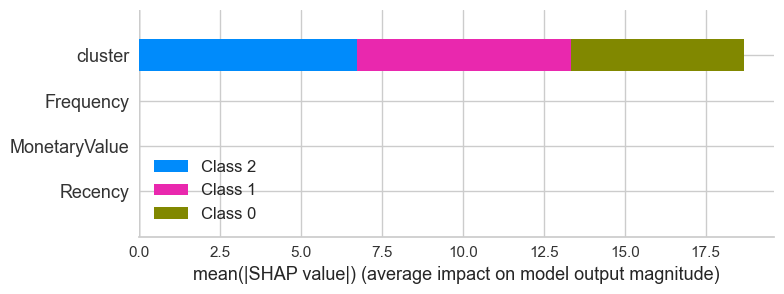

In [131]:
from cv2 import exp
import lightgbm as lgb
from numpy import shape
import shap

clf_km = lgb.LGBMClassifier()

for col in rfm_scaled_no_outliers.columns[1:]:
    rfm_scaled_no_outliers[col] = rfm_scaled_no_outliers[col].astype('category')
    
clf_km.fit(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)

explainer = shap.TreeExplainer(clf_km)
shape_values = explainer.shap_values(rfm_scaled_no_outliers.iloc[:, 1:])
shap.summary_plot(shape_values, rfm_scaled_no_outliers.iloc[:, 1:], plot_type="bar")